In [1]:
import os
import fiona
import matplotlib

matplotlib.use('nbagg')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pyproj import Transformer
from shapely.geometry import Point, Polygon

In [2]:
geodir = os.path.join('..', 'data', 'geometry')

In [3]:
preds = gpd.read_file(os.path.join(geodir, 'predictions.geojson'))
preds = preds.sort_values(by=['timestamp'])

In [4]:
xs = preds.geometry.apply(lambda point: point.x).to_numpy()
ys = preds.geometry.apply(lambda point: point.y).to_numpy()

currs = np.stack((xs, ys), axis=1)
nexts = np.stack((xs, ys), axis=1)[1:]
nexts = np.vstack((nexts, np.zeros(2)))

print(currs.shape)
print(nexts.shape)

(10984, 2)
(10984, 2)


In [5]:
t = Transformer.from_crs(crs_from="epsg:28992", crs_to="epsg:4326", always_xy=True)

voetpad = gpd.read_file(os.path.join(geodir, 'bgt_voetpad.gpkg'))
voetpad.geometry = voetpad.geometry.apply(lambda x: Polygon([t.transform(*coord) for coord in x.exterior.coords]))

f = fiona.open(os.path.join('..', 'data', 'amsterdam-pdok', 'bgt_waterdeel.gml'))
df = {'geometry':[]}

for feature in f:
    if feature['geometry']['type'] == 'Polygon':
        coords = feature['geometry']['coordinates'][0]
        coords = [t.transform(*coord) for coord in coords]
        df['geometry'].append(Polygon(coords))

water = gpd.GeoDataFrame(df)

In [6]:
cmap = matplotlib.cm.get_cmap('Greens').copy()
cmap.set_under('red')
cmap.set_bad('grey')
cmap.set_over(cmap(1))

vmax = max(preds.height_l.max(), preds.height_r.max())
normalize = matplotlib.colors.Normalize(vmin=0, vmax=vmax/8)

height_l = preds.height_l.to_numpy()
height_l[height_l == 0] = -1

height_r = preds.height_r.to_numpy()
height_r[height_r == 0] = -1

cl = [cmap(normalize(v)) for v in height_l]
cr = [cmap(normalize(v)) for v in height_r]

<IPython.core.display.Javascript object>


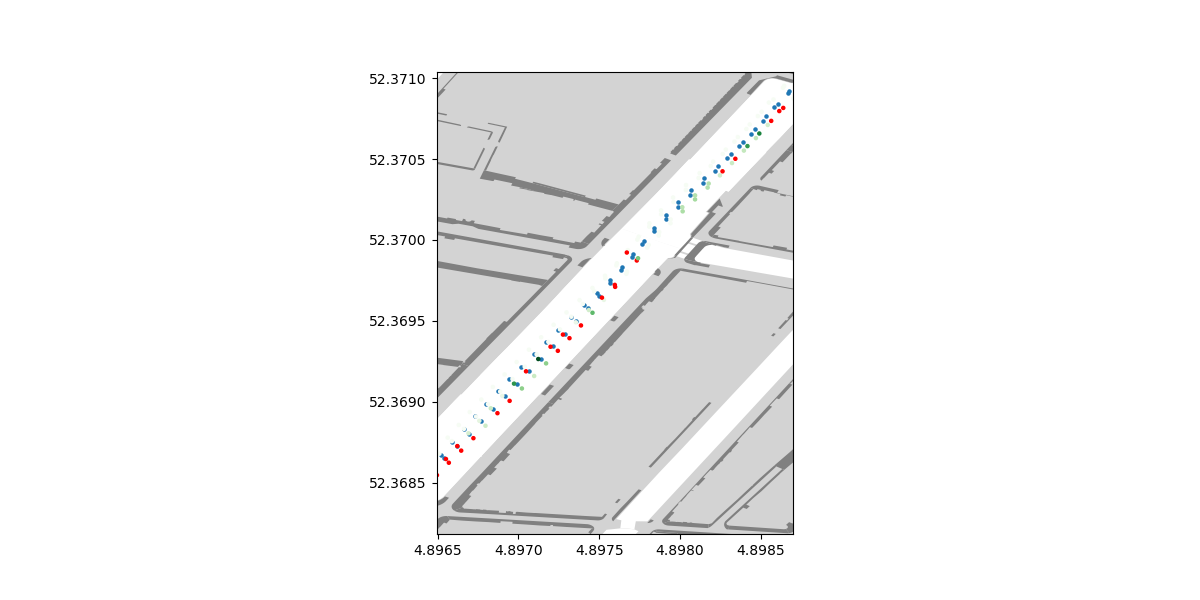

In [7]:
plt.rcParams["figure.figsize"] = (12, 6)

SIZE = 5
U_SCALE = 20

a, b = nexts, currs
diffs = (a - b) / np.linalg.norm(a - b)

u_l = np.stack((-diffs[:, 1], diffs[:, 0]), axis=1)
u_r = np.stack((diffs[:, 1], -diffs[:, 0]), axis=1)

ax = water.plot(color='white')
voetpad.plot(ax=ax, color='grey')

ax.scatter(xs, ys, s=SIZE)
ax.scatter(xs + u_l[:, 0]*U_SCALE, ys + u_l[:, 1]*U_SCALE, color=cl, s=SIZE)
ax.scatter(xs + u_r[:, 0]*U_SCALE, ys + u_r[:, 1]*U_SCALE, color=cr, s=SIZE)

plt.xlim(4.85, 4.95)
plt.ylim(52.34, 52.4)

ax.set_aspect('equal', adjustable='box')
ax.set_facecolor('lightgrey')
plt.show()